Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result.

In [1]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Ignas12345/Project-in-Computational-Biology.git
!mv Project-in-Computational-Biology/* ./

fatal: destination path 'Project-in-Computational-Biology' already exists and is not an empty directory.
mv: cannot stat 'Project-in-Computational-Biology/*': No such file or directory


# Import libs

In [2]:
from models import *
from PIL import Image
from plotting import plot
from converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

factor = 8 # 8

# Load image and baselines

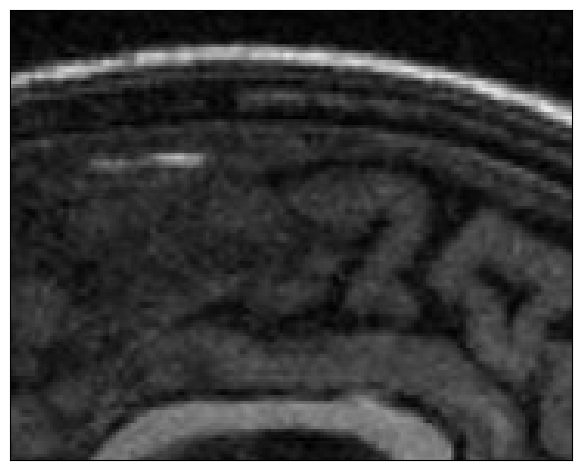

In [3]:
# Starts here
orig_img = Image.open('pictures/MRI_slice_zoomed_in.jpg')
plot([orig_img], cmap='gray')

In [4]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms import v2

def generate_noise(image, upscaling_factor, mean = 0, std_dev = 0.2):
  img_size = np.array(image).shape
  # next line taken from : https://stackoverflow.com/questions/1781970/multiplying-a-tuple-by-a-scalar
  img_size = tuple(i * upscaling_factor for i in img_size)
  noise = np.random.normal(mean, std_dev, img_size)
  #noise = (noise-np.min(noise))/(np.max(noise)-np.min(noise))
  return Image.fromarray(noise)

def image_to_tensor(image):
  tensor = v2.PILToTensor()(image)
  tensor = (tensor-torch.min(tensor))/(torch.max(tensor)-torch.min(tensor))
  #tensor = v2.Normalize([0.5], [0.5])(tensor)
  return tensor.unsqueeze(0)

def tensor_to_image(tensor):
  tensor = tensor.squeeze()
  return v2.ToPILImage()(tensor)

def turn_to_grayscale(image):
  return v2.Grayscale()(image)

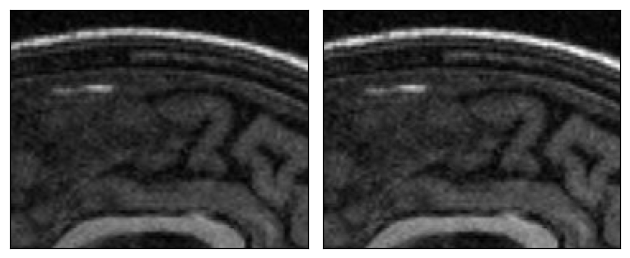

In [5]:
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [6]:
input_depth = 32

INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4:
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
elif factor == 2:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [7]:
net_image = generate_noise(gray_img, upscaling_factor = 8)

In [8]:
net_input = image_to_tensor(net_image).type(dtype).detach()

In [9]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [10]:
torch.Tensor.size(img_LR_var)

torch.Size([1, 1, 145, 181])

# Define closure and optimize

In [11]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


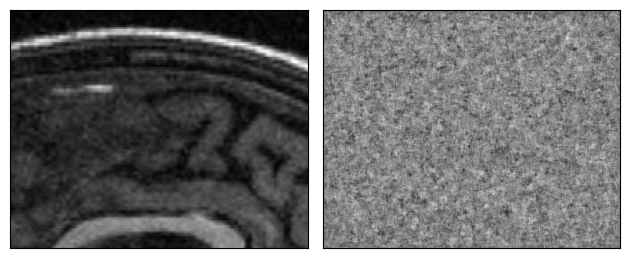

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25


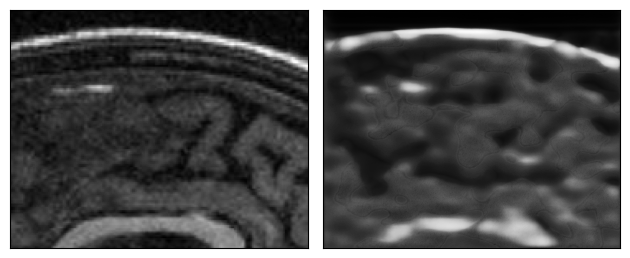

iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50


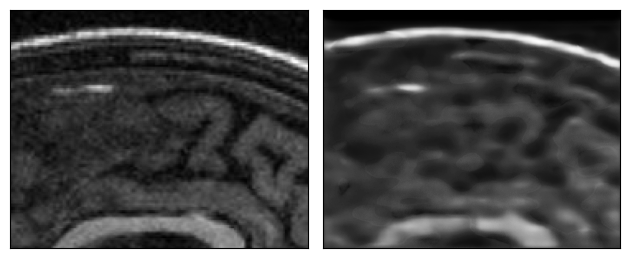

iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75


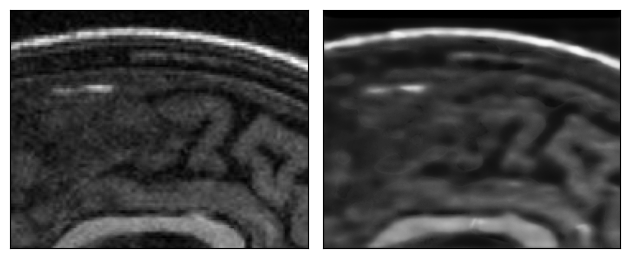

iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99
iteration: 100


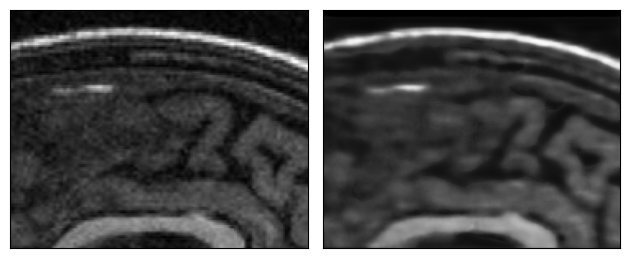

iteration: 101
iteration: 102
iteration: 103
iteration: 104
iteration: 105
iteration: 106
iteration: 107
iteration: 108
iteration: 109
iteration: 110
iteration: 111
iteration: 112
iteration: 113
iteration: 114
iteration: 115
iteration: 116
iteration: 117
iteration: 118
iteration: 119
iteration: 120
iteration: 121
iteration: 122
iteration: 123
iteration: 124
iteration: 125


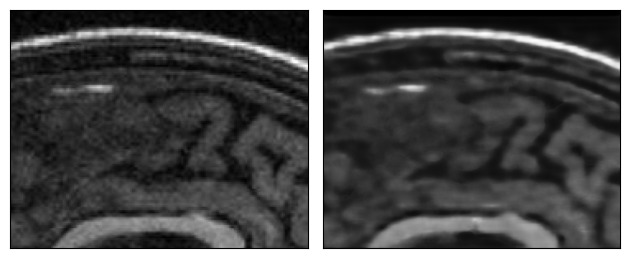

iteration: 126
iteration: 127
iteration: 128
iteration: 129
iteration: 130
iteration: 131
iteration: 132
iteration: 133
iteration: 134
iteration: 135
iteration: 136
iteration: 137
iteration: 138
iteration: 139
iteration: 140
iteration: 141
iteration: 142
iteration: 143
iteration: 144
iteration: 145
iteration: 146
iteration: 147
iteration: 148
iteration: 149
iteration: 150


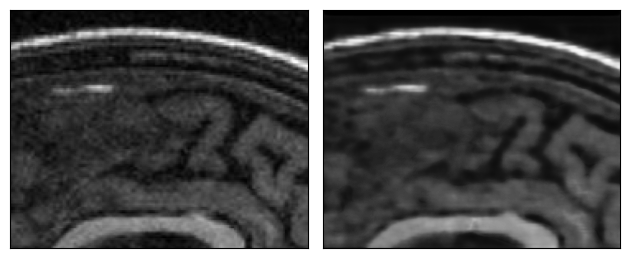

iteration: 151
iteration: 152
iteration: 153
iteration: 154
iteration: 155
iteration: 156
iteration: 157
iteration: 158
iteration: 159
iteration: 160
iteration: 161
iteration: 162
iteration: 163
iteration: 164
iteration: 165
iteration: 166
iteration: 167
iteration: 168
iteration: 169
iteration: 170
iteration: 171
iteration: 172
iteration: 173
iteration: 174
iteration: 175


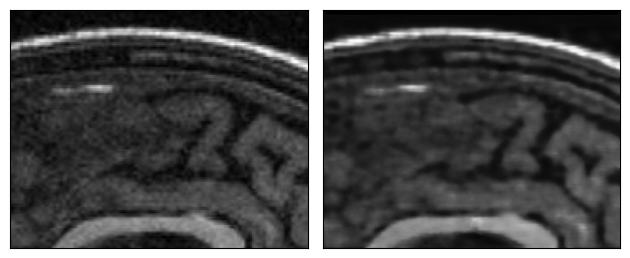

iteration: 176
iteration: 177
iteration: 178
iteration: 179
iteration: 180
iteration: 181
iteration: 182
iteration: 183
iteration: 184
iteration: 185
iteration: 186
iteration: 187
iteration: 188
iteration: 189
iteration: 190
iteration: 191
iteration: 192
iteration: 193
iteration: 194
iteration: 195
iteration: 196
iteration: 197
iteration: 198
iteration: 199
iteration: 200


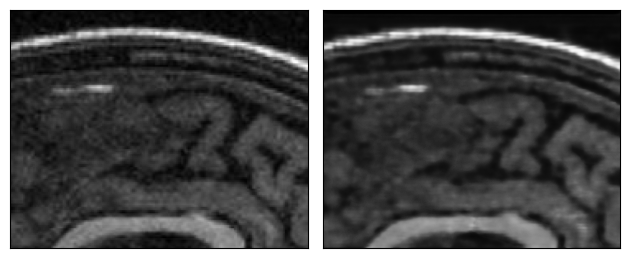

iteration: 201
iteration: 202
iteration: 203
iteration: 204
iteration: 205
iteration: 206
iteration: 207
iteration: 208
iteration: 209
iteration: 210
iteration: 211
iteration: 212
iteration: 213
iteration: 214
iteration: 215
iteration: 216
iteration: 217
iteration: 218
iteration: 219
iteration: 220
iteration: 221
iteration: 222
iteration: 223
iteration: 224
iteration: 225


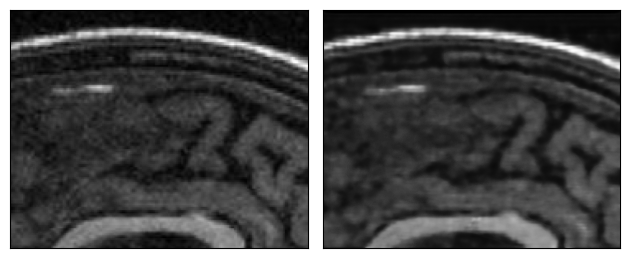

iteration: 226
iteration: 227
iteration: 228
iteration: 229
iteration: 230
iteration: 231
iteration: 232
iteration: 233
iteration: 234
iteration: 235
iteration: 236
iteration: 237
iteration: 238
iteration: 239
iteration: 240
iteration: 241
iteration: 242
iteration: 243
iteration: 244
iteration: 245
iteration: 246
iteration: 247
iteration: 248
iteration: 249
iteration: 250


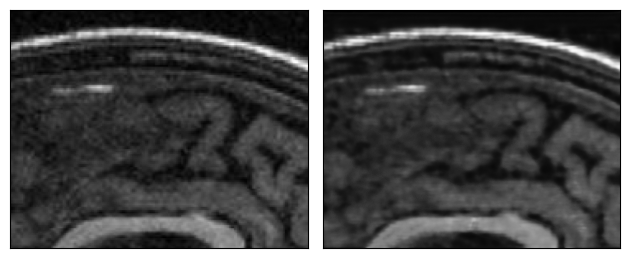

iteration: 251
iteration: 252
iteration: 253
iteration: 254
iteration: 255
iteration: 256
iteration: 257
iteration: 258
iteration: 259
iteration: 260
iteration: 261
iteration: 262
iteration: 263
iteration: 264
iteration: 265
iteration: 266
iteration: 267
iteration: 268
iteration: 269
iteration: 270
iteration: 271
iteration: 272
iteration: 273
iteration: 274
iteration: 275


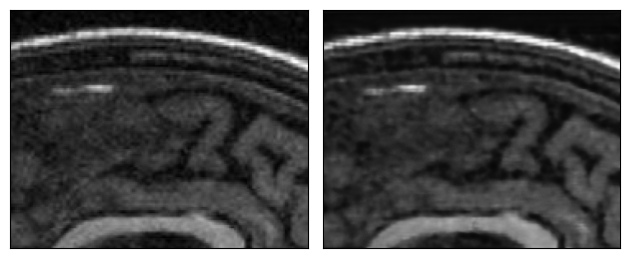

iteration: 276
iteration: 277
iteration: 278
iteration: 279
iteration: 280
iteration: 281
iteration: 282
iteration: 283
iteration: 284
iteration: 285
iteration: 286
iteration: 287
iteration: 288
iteration: 289
iteration: 290
iteration: 291
iteration: 292
iteration: 293
iteration: 294
iteration: 295
iteration: 296
iteration: 297
iteration: 298
iteration: 299
iteration: 300


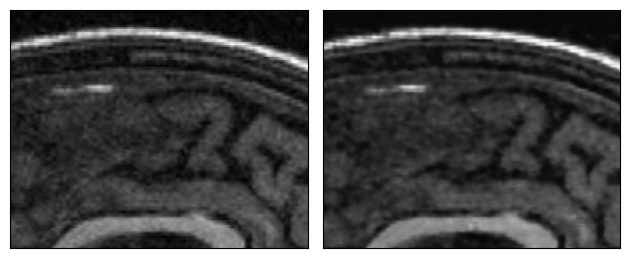

iteration: 301
iteration: 302
iteration: 303
iteration: 304
iteration: 305
iteration: 306
iteration: 307
iteration: 308
iteration: 309


KeyboardInterrupt: 

In [12]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)

In [ ]:
out_HR_pil = np_to_pil(out_HR_np)

In [ ]:
plot_image_grid([out_HR_np], 4, 4);